In [3]:
import os
base_dir = '/Users/jw1010110/AI/car-dataset'

train_dir = os.path.join(base_dir,'train') #train 폴더 경로
validation_dir = os.path.join(base_dir,'validation')#validation 폴더 경로

train_sedan_dir = os.path.join(train_dir,'sedan')
train_suv_dir = os.path.join(train_dir,'suv')

validation_sedan_dir = os.path.join(validation_dir,'sedan')
validation_suv_dir = os.path.join(validation_dir,'suv')

print(len(os.listdir(train_sedan_dir)))
print(len(os.listdir(train_suv_dir)))
print(len(os.listdir(validation_sedan_dir)))
print(len(os.listdir(validation_suv_dir)))

119
119
59
59


In [4]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3)) #별도의 세단과 suv 클래스 2개를 구분하는 완전 연결층 추가할거임

Metal device set to: Apple M1 Pro


2022-06-14 12:37:35.204342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-14 12:37:35.204477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
#합성곱 기반층 위에 완전 연결 분류기 추가
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) #4*4*512=8192
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
#사전에 학습된 표현이 훈련되는 동안 수정되는 것을 방지하기 위해 동결
conv_base.trainable = False

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=6,
                              epochs=100,
                              validation_data=validation_generator,
                             validation_steps=3)

Found 238 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Epoch 1/100


/var/folders/pn/m2bqkk014sv8108lk7tl4xy80000gn/T/ipykernel_34487/1115708154.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-06-14 12:50:41.981311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.3001 - acc: 0.9083

2022-06-14 12:50:42.955803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 171ms/step - loss: 0.3001 - acc: 0.9083 - val_loss: 0.2228 - val_acc: 0.8833
Epoch 2/100
6/6 [==============================] - 1s 144ms/step - loss: 0.0228 - acc: 1.0000 - val_loss: 0.5132 - val_acc: 0.8833
Epoch 3/100
6/6 [==============================] - 1s 149ms/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.4077 - val_acc: 0.8833
Epoch 4/100
6/6 [==============================] - 1s 138ms/step - loss: 0.1537 - acc: 0.9333 - val_loss: 0.8506 - val_acc: 0.7833
Epoch 5/100
6/6 [==============================] - 1s 145ms/step - loss: 0.0682 - acc: 0.9750 - val_loss: 0.3446 - val_acc: 0.8500
Epoch 6/100
6/6 [==============================] - 1s 138ms/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.3324 - val_acc: 0.8833
Epoch 7/100
6/6 [==============================] - 1s 138ms/step - loss: 0.0569 - acc: 0.9833 - val_loss: 1.1448 - val_acc: 0.7333
Epoch 8/100
6/6 [==============================] - 1s 144ms/step - loss: 0.0453 - acc: 0.9917 -

6/6 [==============================] - 1s 150ms/step - loss: 0.0179 - acc: 1.0000 - val_loss: 1.3046 - val_acc: 0.7833
Epoch 64/100
6/6 [==============================] - 1s 154ms/step - loss: 0.0306 - acc: 0.9750 - val_loss: 0.6149 - val_acc: 0.8667
Epoch 65/100
6/6 [==============================] - 1s 150ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.4308 - val_acc: 0.9000
Epoch 66/100
6/6 [==============================] - 1s 151ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.4228 - val_acc: 0.8833
Epoch 67/100
6/6 [==============================] - 1s 155ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.3371 - val_acc: 0.9000
Epoch 68/100
6/6 [==============================] - 1s 149ms/step - loss: 7.7355e-04 - acc: 1.0000 - val_loss: 0.4536 - val_acc: 0.9000
Epoch 69/100
6/6 [==============================] - 1s 151ms/step - loss: 0.1077 - acc: 0.9583 - val_loss: 0.4941 - val_acc: 0.8333
Epoch 70/100
6/6 [==============================] - 1s 142ms/step - loss: 0.0232 - ac

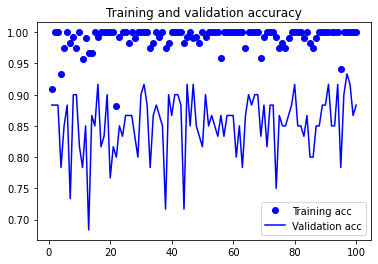

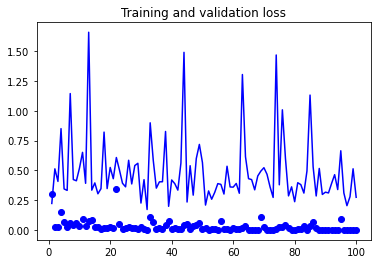

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('Training and validation loss')

plt.show()

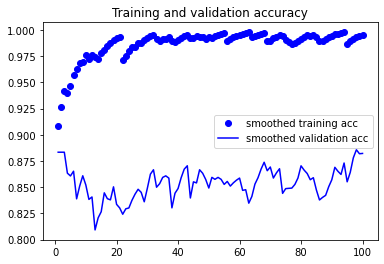

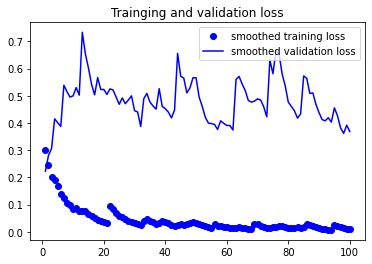

In [20]:
#지수평균이동으로 부드러운 그래프
def smooth_curve(points, factor=0.8): 
    smoothed_points = []
    for point in points: 
        if smoothed_points: # not empty
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else:
            smoothed_points.append(point) 
    return smoothed_points

plt.plot(epochs,smooth_curve(acc),'bo',label='smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc),'b',label='smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,smooth_curve(loss),'bo',label='smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss),'b',label='smoothed validation loss')
plt.title('Trainging and validation loss')
plt.legend()

plt.show()

In [24]:
#특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [25]:
#모델 미세조정

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=1e-5),metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=6,
                              epochs=20,
                              validation_data=validation_generator,
                             validation_steps=3)

Epoch 1/20


/var/folders/pn/m2bqkk014sv8108lk7tl4xy80000gn/T/ipykernel_34487/2071223682.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,
2022-06-14 12:53:56.760754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.0343 - acc: 0.9915 

2022-06-14 12:53:57.953479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 191ms/step - loss: 0.0343 - acc: 0.9915 - val_loss: 0.4788 - val_acc: 0.8667
Epoch 2/20
6/6 [==============================] - 1s 149ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.4434 - val_acc: 0.8833
Epoch 3/20
6/6 [==============================] - 1s 144ms/step - loss: 6.6575e-05 - acc: 1.0000 - val_loss: 0.7424 - val_acc: 0.8167
Epoch 4/20
6/6 [==============================] - 1s 158ms/step - loss: 1.6422e-04 - acc: 1.0000 - val_loss: 0.5922 - val_acc: 0.8667
Epoch 5/20
6/6 [==============================] - 1s 144ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.3861 - val_acc: 0.9000
Epoch 6/20
6/6 [==============================] - 1s 139ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.5174 - val_acc: 0.8667
Epoch 7/20
6/6 [==============================] - 1s 143ms/step - loss: 4.4295e-04 - acc: 1.0000 - val_loss: 0.5470 - val_acc: 0.8667
Epoch 8/20
6/6 [==============================] - 1s 138ms/step - loss: 5.5606e-04 - acc:

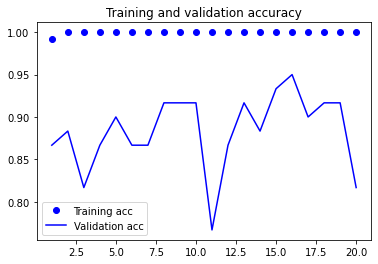

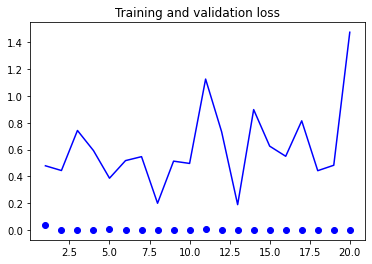

In [26]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('Training and validation loss')

plt.show()

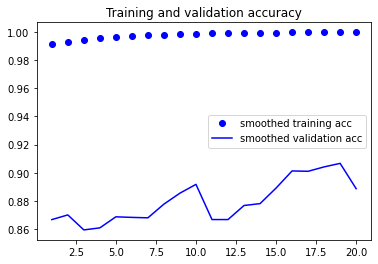

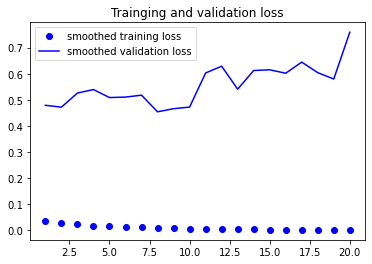

In [27]:
#지수평균이동으로 부드러운 그래프
def smooth_curve(points, factor=0.8): 
    smoothed_points = []
    for point in points: 
        if smoothed_points: # not empty
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor)) 
        else:
            smoothed_points.append(point) 
    return smoothed_points

plt.plot(epochs,smooth_curve(acc),'bo',label='smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc),'b',label='smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,smooth_curve(loss),'bo',label='smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss),'b',label='smoothed validation loss')
plt.title('Trainging and validation loss')
plt.legend()

plt.show()

In [30]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np
base_dir = '/Users/jw1010110/AI/car-dataset/eval1'
base_dir1 = '/Users/jw1010110/AI/car-dataset/evaluate'

test_datagen =ImageDataGenerator(rescale=1./255)
test_generator =test_datagen.flow_from_directory(base_dir1,target_size=(150,150),batch_size=10,class_mode='binary')
test_loss, test_acc =model.evaluate(test_generator,steps=2)
print(test_acc)


pic1_datagen = ImageDataGenerator(rescale=1./255)
pic1_generator = pic1_datagen.flow_from_directory(base_dir,target_size=(150,150),batch_size=1,class_mode='binary')
pic1_loss, pic1_acc =model.evaluate(pic1_generator,steps=1)
print(pic1_acc)

# img = image.load_img(base_dir, target_size=(150,150))
# x = image.img_to_array(img)
# x = np.expand_dims(x,axis=0)

# x = preprocess_input(x)

# results = model.predict(x)
# #print(results)
# print(decode_predictions(results))

Found 20 images belonging to 2 classes.
2/2 [==============================] - 0s 40ms/step - loss: 1.0972 - acc: 0.8000
0.800000011920929
Found 2 images belonging to 2 classes.
1/1 [==============================] - 0s 68ms/step - loss: 3.3512 - acc: 0.0000e+00
0.0
